In [104]:
import numpy as np #necessary basic tools...
import itertools

from nltk.corpus import words #training example...

from PIL import Image ##imaging...
import seaborn as sns
import matplotlib.pyplot as plt



words_list = words.words()
words_list = [x for x in words_list if len(x) >=2]


Utilitary functions:

In [105]:
def asvoid(arr):
    """View the array as dtype np.void (bytes)
    This collapses ND-arrays to 1D-arrays, so you can perform 1D operations on them.
    https://stackoverflow.com/a/16216866/190597 (Jaime)"""    
    arr = np.ascontiguousarray(arr)
    return arr.view(np.dtype((np.void, arr.dtype.itemsize * arr.shape[-1])))

def find_index(arr, x):
    arr_as1d = asvoid(arr) # thank you to stack overflow (same link as above)
    x = asvoid(x)
    return np.nonzero(arr_as1d == x)[0]


# Word Generation With N-Grams

The N-Gram model gives probability distributions on strings for a given language. For example, in French, the word "xyloqsjdfkljsdfqmskfdl" has a smaller probablity of being a valid word than "xylophone". <big>How much smaller?</big> The answer to this question will enable us to create new words.

### 1. The trainable model

Our model will predict the likeliness of a token given the $n$ preceding tokens. Tokens could be letters or words **but an end token is needed.** In python this does not exist, so we'll have to add it at the end of strings ourselves. We will also add $n$ end-tokens at the beginning of a string, and start analyzing the string when at the first non ending character. Let $\mathcal{T}$ be the set of tokens. Here we will make an *updateable* model, that estimates the $|\mathcal{T}|^{n+1}$ parameters of the model. The parameters are the probability that an $n$-gram (sequence of $n$ tokens) is followed by any given token, for all tokens and for all $n$-grams. Let $f:\mathcal{T}\times \mathcal{T}^{n} \to [0,1]$ be  defined as $$\forall t \in \mathcal{T}, w \in \mathcal{T}^n, f(t,w) := P(t | w).$$ Note that $$f(t,w)\approx \frac{\char"0023 w.t}{\char"0023 w},$$ where $\char"0023$ stands for "the count of", and $.$ stands for string concatenation, aka "followed by". This model stores the parameters as :

- The raw counts of each $n+1$-gram, as a one dimensional array. 

Note that from the raw counts of each $n+1$-gram we can deduce the count of any $n$-gram. These two elements make it possible to reconstitute a $|\mathcal{T}|\times |\mathcal{T}|^n$ matrix, containing the associated probabilities. This model will be updated with new strings.


In [106]:
class Ngram:
    def find_nplusonegram_ending_at_index(tokenized,i,n):
        return np.array(tokenized[i-n-1:i])

    def __init__(self, n,tokenizer,end_token,alphabet:list):
        self.tokenizer = tokenizer
        self.n = n
        self.end_token = end_token
        
        self.alphabet:np.array = (np.unique(np.array(alphabet+[end_token])))# initialize alphabet as an array of all possible tokens, **including the end token**. 

        self.nplusone_grams:np.array = np.array(([np.array(p) for p in itertools.product(self.alphabet, repeat=self.n+1)]))# initialize all possible ngrams by using the alphabet. 
        self.raw_count_of_each_n_plus_one_gram = np.zeros((self.nplusone_grams.shape[0]),dtype=np.int64)

    def tokenize(self,s:str):
        return ([self.end_token]*self.n+self.tokenizer(s)+[self.end_token])
        
    def update_from_file(self,path:str):
        ... # Extract the list, and use update_from_list

    def update_from_list(self,l:list[str]):
        # PARAM list must be a list of strings
        for w in l:# for each string in the list, 
            t = self.tokenize(w)
            for i in range(self.n+1,len(t)+1):# for each token in the string, starting at token index n, including the ending token,
                nplusone_gram = Ngram.find_nplusonegram_ending_at_index(tokenized=t,i=i,n=self.n)
                index = find_index(self.nplusone_grams,nplusone_gram)[0]
                self.raw_count_of_each_n_plus_one_gram[index] += 1  # update the count of the corresponding nplusone-gram
        

    def n_gram_count(self, n_gram):
        total = 0
        for tok in self.alphabet:
            index = find_index(self.nplusone_grams,n_gram+[tok])[0]
            total += self.raw_count_of_each_n_plus_one_gram[index]
        return total

    def f(self,t:str,w:list[str]):
        # t is a token
        # w is a list of tokens

        big_word_count = self.raw_count_of_each_n_plus_one_gram[find_index(self.nplusone_grams, np.array(list(w)+[t]))[0]]
        return 0 if big_word_count==0 else big_word_count/self.n_gram_count(list(w))#estimate f(t,w) based on counts of t.w and counts of w.
        


Because we are modelizing strings as Markov chains of order $n$, we can write, for $w\in \mathcal{T}^m, m\in \mathbb{N}_{>n},$ $$P(w)=\prod_{i=1}^m P(w_i|w_{i-n+1:i-1}).$$
This can be used for classification, by picking the right threshold after which the probability is to low (for example, knowing the distributions, we can choose $\alpha$ using the Neymann-Pearson lemma).

In [ ]:

def probability(self, s:str):
    prod = 1 # the initial product value is 1
    tokenized = self.tokenize(s)# tokenize s.
    for i in range(self.n,len(tokenized)+1):# for each token t in s, starting at index n, excluding the ending token,
        t = tokenized[i]
        if t == self.end_token:
            break
        w = Ngram.find_nplusonegram_ending_at_index(tokenized,i,self.n-1) # given the preceding n-gram (:=w)
        prod *= self.f(t,w)
    return prod

Ngram.probability = probability



The following code should now work:

In [107]:
N = 2
END_TOKEN = '\x00'
PATH_TO_STRINGS_CSV = ...
ALPHABET = [c for c in "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ-"]

def t(s:str): #string padding will be done 
    # example tokenizer
    l = [c for c in s] # tokenize by char
    assert all(c in ALPHABET for c in l) # assert that the input matches the alphabet
    return l

model_fr = Ngram(n=N,tokenizer=t,end_token=END_TOKEN,alphabet=ALPHABET) # generate new model from constructor, choosing n and a tokenizer (it must also be possible to `load` a model from csv)


model_fr.update_from_list(["chaussettes","chien"])# train the model using a list of strings



In [108]:
model_fr.probability("chien") #afaik with N=3 without training with a big CSV file, this should be 1/2 because the probability that i follows ch is 1/2, and all other probabilities in chien are 1.

0.16666666666666666

We can also define a plotting function:

In [165]:

def plot(self):
    matArr = [[self.f(w[-1],w[:-1]) for w in [i for i in self.nplusone_grams if i[-1]==t]] for t in self.alphabet]


    fig, ax = plt.subplots(figsize=(10,10))  

    labels_y = self.alphabet
    labels_x = [w[:-1][0] for w in [i for i in self.nplusone_grams if i[-1] == ""]]

    ax = sns.heatmap(matArr, linewidth=1,xticklabels=1,yticklabels=1,ax=ax)
    ax.set_xlabel("Prefix $w$")
    ax.set_ylabel("Suffix $t$")
    ax.set_title("Probability of the $n+1$ gram $w.t$")
    ys = range(labels_y.shape[0])
    def format_y(tick_val, tick_pos):
        if int(tick_val) in ys:
            return labels_y[int(tick_val)]
        else:
            return ''


    ax.yaxis.set_major_formatter(format_y)

    xs= range(len(labels_x))
    def format_x(tick_val, tick_pos):
        if int(tick_val) in xs:
            return labels_x[int(tick_val)]
        else:
            return ''


    ax.xaxis.set_major_formatter(format_x)

    plt.show()

Ngram.plot = plot

Let us train a new model with the nltk word database by batches and show the result.

In [109]:
model_en = Ngram(n=N,tokenizer=t,end_token=END_TOKEN,alphabet=ALPHABET)
model_en.update_from_list(words_list[:10000]) # train on all words in the English language

In [110]:
model_en.update_from_list(words_list[10000:20000]) # train on all words in the English language

In [111]:
model_en.update_from_list(words_list[20000:30000]) # train on all words in the English language

In [112]:
model_en.update_from_list(words_list[30000:40000])

In [113]:
model_en.update_from_list(words_list[40000:50000])

In [114]:
model_en.update_from_list(words_list[50000:100000])

In [115]:
model_en.update_from_list(words_list[100000:150000])

In [116]:
model_en.update_from_list(words_list[150000:200000])

In [117]:
model_en.update_from_list(words_list[200000:])

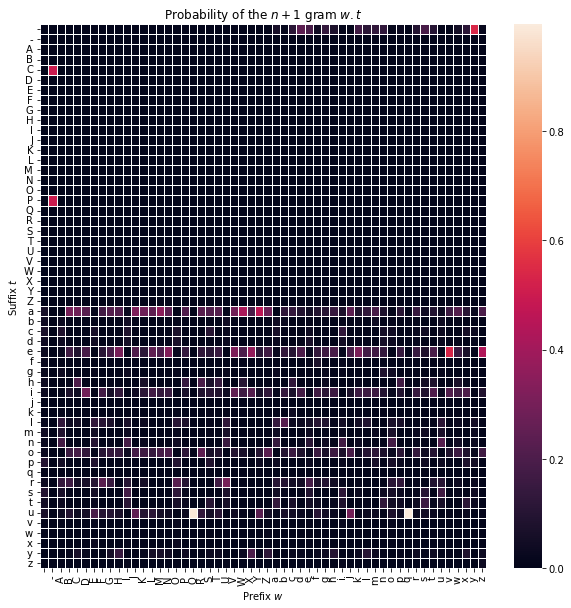

In [166]:
model_en.plot()

In [119]:
model_en.probability("Jezebelish")

1.2062902090706875e-14

Let's now train using a CSV file.

In [120]:
model_fr.update_from_file(PATH_TO_STRINGS_CSV)# train the model using a csv file containing correct strings

We can now implement storing and loading. Note that the following code is not as important as what comes before. If you are implementing this, what you did works ok and you don't feel like implementing stores and loads, just go to part 2.

In [121]:
PATH_TO_MODEL_JSON = ...

def store(self,path:str):
    ...#the file must contain:
    ...# all attributes of self except tokenizer (impossible to serialize afaik)
    # loaded models will GUESS the type of tokenization to be by-letter


def load_from(path:str)->Ngram:
    ...

Ngram.store = store
Ngram.load_from = load_from

The following should now be possible:

In [122]:
model_fr.store(PATH_TO_MODEL_JSON) # store the model in a file
#do stuff with the model
model_fr = Ngram.load_from(PATH_TO_MODEL_JSON) # restart the model to where it was before, from memory.



The end product of this first part is to determine the probability of any given string.

### 2. Word generation

Time to generate new words! To do so, we will need strings of tokens that have their beginning padded with $n$ end-tokens. We will look at the most likely token to follow in the table obtained before.

First, let us define a function that finds the most likely following token, given an $n$-gram.

In [152]:
def next_token(self, s:str):
    alphabet = self.alphabet if len(s) >= self.n else np.delete(self.alphabet,np.where(self.alphabet==self.end_token)[0]) # we want to generate words of size at least n


    probas = np.array([self.f(t,s[-self.n:]) for t in alphabet])

    choice = np.random.choice(alphabet,p=probas)

    return choice # search in self.alphabet for the token that is most likely using self.probability (you can use np.argmax, with, for t in self.alphabet, self.probability(s+t) as a function to maximize)



Ngram.next_token = next_token

Finally, we can use next_token to generate new words:

In [155]:
def generate(self):
    s:str = "".join(np.random.choice(np.delete(self.alphabet,np.where(self.alphabet==self.end_token)[0]),1)) #pick a random 1gram from self.alphabet **that is not self.end_token**. For this you can use np.random for example.
    while True:
        t = self.next_token(s).lower()
        # print(f"Found token {t}, {t==self.alphabet[np.where(self.alphabet==self.end_token)[0]]}")
        if t==self.alphabet[np.where(self.alphabet==self.end_token)[0]]: # if t == self.end_token, but due to numpy encodings it is written differently
            break
        else:
            s += str(t)
    return s

Ngram.generate = generate


Last step!

In [163]:
[model_en.generate() for i in range(100)]

['Leprin',
 'xiandvis',
 'Haliniscreximbihe',
 'Karcth',
 'juatalenorbeom',
 'hisede',
 'acomeabary',
 'Chminl',
 'blantrdarigaraclariericl',
 'Iteristed',
 'Dhonpsaly',
 'hesatoar',
 'ycoglifowegrmalig',
 'Xic',
 'ma',
 'rilacios',
 'Satumyl',
 'ym',
 'Guisemitovethicke',
 'Godag',
 'Jetotheaxidoparennapat',
 'weraraug',
 'Anve',
 'og',
 'Pogn',
 'Acly',
 'lesa',
 'Orct',
 'nintech',
 'howhyprom',
 'dabraury',
 'glve',
 'g',
 'hat',
 'Yudatos',
 'pene',
 'Te',
 'Bogans',
 'Pobakiocosesydoprowictalgra',
 'Grserifoclein',
 'Itedivab',
 'katerenthimarooaricaionicaed',
 'Eunatelzzatere',
 'Ateminiafine',
 'xparochnuapsprfuse',
 'sissy',
 'Kariarely',
 'Gume',
 'pado',
 'Tor',
 'g',
 'l',
 'Oghorlletioshicr',
 'Bretialemupher',
 'qungligeesad',
 'oniuroisedaurmisistare',
 'En',
 'Mopitexerapalicleotonteglilyp',
 'Gontesteratequloremary',
 'y',
 'Scachay',
 'Innesyhodaclios',
 'Tatoocopitrerene',
 'xtrargine',
 'er',
 'veadove',
 'ganffetikeline',
 'Khonathincorangr',
 'Gncrt',
 'Thn',
 'Xi